In [ ]:
%config Completer.use_jedi = False
%config InlineBackend.figure_formats = ['svg']

# Using composition

In [ ]:
# !pip install matplotlib==3.3.3 sympy==1.7.1

In [ ]:
from typing import Tuple

import attr
import sympy as sp
from helpers import (
    StateTransitionGraph,
    blatt_weisskopf,
    determine_attached_final_state,
    two_body_momentum_squared,
)

try:
    from typing import Protocol
except ImportError:
    from typing_extensions import Protocol  # type: ignore

A frozen `DynamicExpression` class keeps track of `variables`, `parameters`, and the dynamics `expression` in which they should appear:

In [ ]:
@attr.s(frozen=True)
class DynamicsExpression:
    variables: Tuple[sp.Symbol, ...] = attr.ib()
    parameters: Tuple[sp.Symbol, ...] = attr.ib()
    expression: sp.Expr = attr.ib()

    def substitute(self) -> sp.Expr:
        return self.expression(*self.variables, *self.parameters)

The `expression` attribute can be formulated as a simple Python function that takes `sympy.Symbol`s as arguments and returns a `sympy.Expr`:

In [ ]:
def relativistic_breit_wigner(
    mass: sp.Symbol, mass0: sp.Symbol, gamma0: sp.Symbol
) -> sp.Expr:
    return gamma0 * mass0 / (mass0 ** 2 - mass ** 2 - gamma0 * mass0 * sp.I)

In [ ]:
def relativistic_breit_wigner_with_form_factor(
    mass: sp.Symbol,
    mass0: sp.Symbol,
    gamma0: sp.Symbol,
    m_a: sp.Symbol,
    m_b: sp.Symbol,
    angular_momentum: sp.Symbol,
    meson_radius: sp.Symbol,
) -> sp.Expr:
    q_squared = two_body_momentum_squared(mass, m_a, m_b)
    q0_squared = two_body_momentum_squared(mass0, m_a, m_b)
    ff2 = blatt_weisskopf(q_squared, meson_radius, angular_momentum)
    ff02 = blatt_weisskopf(q0_squared, meson_radius, angular_momentum)
    width = gamma0 * (mass0 / mass) * (ff2 / ff02)
    width = width * sp.sqrt(q_squared / q0_squared)
    return (
        relativistic_breit_wigner(mass, mass0, width)
        * mass0
        * gamma0
        * sp.sqrt(ff2)
    )

The `DynamicsExpression` container class enables us to provide the `expression` with correctly named `Symbol`s for the decay that is being described. Here, we use some naming scheme for an $f_0(980)$ decaying to final state edges 3 and 4 (say $\pi^0\pi^0$):

In [ ]:
bw_decay_f0 = DynamicsExpression(
    variables=sp.symbols("m_3+4", seq=True),
    parameters=sp.symbols(R"m_f(0)(980) \Gamma_f(0)(980)"),
    expression=relativistic_breit_wigner,
)
bw_decay_f0.substitute()

\Gamma_f(0)(980)*m_f(0)(980)/(-I*\Gamma_f(0)(980)*m_f(0)(980) - m_3+4**2 + m_f(0)(980)**2)

For each dynamics expression, we have to provide a 'builder' function that can create a `DynamicsExpression` for a specific edge within the `StateTransitionGraph`:

In [ ]:
def relativistic_breit_wigner_from_graph(
    graph: StateTransitionGraph, edge_id: int
) -> DynamicsExpression:
    edge_ids = determine_attached_final_state(graph, edge_id)
    final_state_ids = map(str, edge_ids)
    mass = sp.Symbol(f"m_{{{'+'.join(final_state_ids)}}}")
    particle, _ = graph.get_edge_props(edge_id)
    mass0 = sp.Symbol(f"m_{{{particle.latex}}}")
    gamma0 = sp.Symbol(fR"\Gamma_{{{particle.latex}}}")
    return DynamicsExpression(
        variables=(mass),
        parameters=(mass0, gamma0),
        expression=relativistic_breit_wigner(mass, mass0, gamma0),
    )

In [ ]:
def relativistic_breit_wigner_with_form_factor_from_graph(
    graph: StateTransitionGraph, edge_id: int
) -> DynamicsExpression:
    edge_ids = determine_attached_final_state(graph, edge_id)
    final_state_ids = map(str, edge_ids)
    mass = sp.Symbol(f"m_{{{'+'.join(final_state_ids)}}}")
    particle, _ = graph.get_edge_props(edge_id)
    mass0 = sp.Symbol(f"m_{{{particle.latex}}}")
    gamma0 = sp.Symbol(fR"\Gamma_{{{particle.latex}}}")
    m_a = sp.Symbol(f"m_{edge_ids[0]}")
    m_b = sp.Symbol(f"m_{edge_ids[1]}")
    angular_momentum = particle.spin  # helicity formalism only!
    meson_radius = sp.Symbol(fR"R_{{{particle.latex}}}")
    return DynamicsExpression(
        variables=(mass),
        parameters=(mass0, gamma0, m_a, m_b, angular_momentum, meson_radius),
        expression=relativistic_breit_wigner_with_form_factor(
            mass, mass0, gamma0, m_a, m_b, angular_momentum, meson_radius
        ),
    )

The fact that `DynamicsExpression.expression` is just a Python function, allows one to inspect the dynamics formulation of these functions **independently**, purely in terms of SymPy:

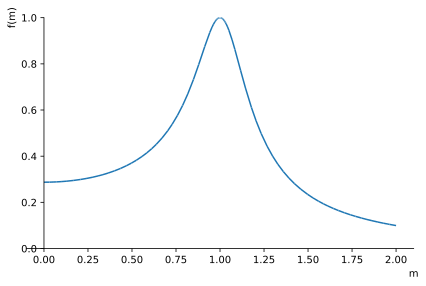

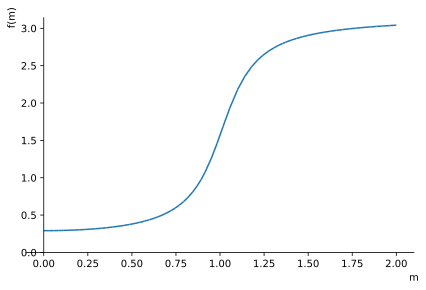

\Gamma*m_0/(-I*\Gamma*m_0 - m**2 + m_0**2)

In [ ]:
m, m0, w0 = sp.symbols(R"m m_0 \Gamma")
evaluated_bw = relativistic_breit_wigner(m, 1.0, 0.3)
sp.plot(sp.Abs(evaluated_bw), (m, 0, 2), axis_center=(0, 0), ylim=(0, 1))
sp.plot(sp.arg(evaluated_bw), (m, 0, 2), axis_center=(0, 0), ylim=(0, sp.pi))
relativistic_breit_wigner(m, m0, w0)

This closes the gap between the code and the theory that is being implemented.

## Alternative signature

An alternative way to specify the expression is:

In [ ]:
def expression(
    variables: Tuple[sp.Symbol, ...], parameters: Tuple[sp.Symbol, ...]
) -> sp.Expr:
    pass

Here, one would however need to unpack the `variables` and `parameters`. The advantage is that the signature becomes more general.

## Type checking

There is no way to enforce the appropriate signature on the builder function, other than following a {class}`~typing.Protocol`:

In [ ]:
class DynamicsBuilder(Protocol):
    def __call__(
        self, graph: StateTransitionGraph, edge_id: int
    ) -> DynamicsExpression:
        ...

This `DynamicsBuilder` protocol would be used in the syntax proposed at {ref}`adr/002:Considered solutions`.

It carries another subtle problem, though: a {class}`~typing.Protocol` is only used in static type checking, while potential problems with the implementation of the builder and its respective expression only arrise at runtime.